# Machine Learning LAB 4: CLASSIFICATION - Characters Classification with Neural Networks

Course 2023/24: *M. Caligiuri*, *P. Talli*, *F. Lincetto*, *F. Chiariotti*, *P. Zanuttigh*

The notebook contains some simple tasks about **CLASSIFICATION**.

Complete all the **required code sections** and **answer to all the questions**.

### IMPORTANT for the evaluation score:

1. **Read carefully all cells** and **follow the instructions**.
2. **Re-run all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
3. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
4. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command**.
5. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

## Characters Classification with Neural Networks

In this notebook we are going to use the **Neural Networks** for image classification. We are going to use a dataset of traditional japanese handwritten kana: [*Kuzushiji-MNIST*](https://github.com/rois-codh/kmnist) (or *K-MNIST* for short).

The dataset labels are the following:

| Label | Hiragana Character | Romanji (Pronunciation) |
| :-: | :-: | :-: |
|   0   | お | o |
| 1 | き | ki |
| 2 | す | su |
| 3 | つ | tsu |
| 4 | な | na |
| 5 | は | ha |
| 6 | ま | ma |
| 7 | や | ya |
| 8 | れ | re |
| 9 | を | wo |

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB04.ipynb**, failure to do so will incur in a **lower grade**.

**Student name**: Ada D'Iorio

**ID Number**: 2092320

---

## Import all the necessary Python libraries

In [1]:
%matplotlib inline  

import os
import gzip
from time import time
from copy import deepcopy as cp
import typing as tp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

---

## Define the heplper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `load_mnist` -> function to load the K-MNIST dataset,
2. `plot_input` -> function to plot the input image,
3. `param_count`-> function to compute the number of learnable parameters of a MLP given the size of its hidden layers,
4. `plot_accuracies` -> function to plot the accuracies of the MLP,
5. `plot_losses` -> function to plot the losses of the MLP,
6. `plot_conf_matrix` -> function to plot the confusion matrix of the MLP.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
def load_mnist(path: str, kind: str = 'train') -> tp.Tuple[np.ndarray, np.ndarray]:
    # Define the path to the data
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind)
    
    # Load the data into numpy arrays (from the gzip files)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    
    return images, labels

In [3]:
#function for plotting a image and printing the corresponding label
def plot_input(data: np.ndarray, labels: np.array, index: int or tp.List[int]) -> None:
    if type(index) == int:
        index = [index]
    
    _, ax = plt.subplots(1, len(index))

    if type(ax) != np.ndarray:
        ax = [ax]

    for i, ax in enumerate(ax):
        ax.imshow(
            data[i].reshape(28, 28),
            cmap=plt.cm.gray_r,
            interpolation="nearest"
        )
        ax.set_title("Label: %i" % labels[i])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
def param_count(hl_size: int, x: np.ndarray, y: np.ndarray) -> int:
    tot = 0
    input_size, output_size = x.shape[1], len(y)
    tot += (input_size+1)*hl_size[0]
    for i in range(1,len(hl_size)):
        tot += (hl_size[i-1]+1)*hl_size[i]
    tot += (hl_size[-1]+1)*output_size
    return tot

In [5]:
def plot_accuracies(accuracies: tp.List[float], hl_labels: tp.List[str], titles: tp.List[str] = None) -> None:
    _, ax = plt.subplots(1, len(accuracies), figsize=(6 * len(accuracies), 5)) 

    if type(ax) != np.ndarray:
        ax = [ax]
    
    for i, ax in enumerate(ax):
        ax.plot(accuracies[i])
        ax.set_xlabel("Number of learnable params")
        ax.set_title("Accuracy")
        ax.set_xticks(np.arange(len(hl_labels))) #ho tolto hl_labels[i]
        ax.set_xticklabels(hl_labels)
        if titles is not None and len(titles) > i:
            ax.set_title(titles[i])
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def plot_loss(losses: tp.Dict[float, np.ndarray]) -> None:
    legend = True

    # Plot all the losses
    for key, value in losses.items():
        if key == None:
            plt.plot(value)
            legend = False
        else:
            plt.plot(value, label=f"lr: {key}")

    # Plot the legend, title and labels
    plt.title("Losses")
    if legend:
        plt.legend(loc = 1)
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")

    plt.tight_layout()
    plt.show()
    plt.close()

In [7]:
def plot_conf_matrix(conf_matrix: np.ndarray) -> None:
    # Plot the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d",)
    plt.title("Confusion matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.tight_layout()
    plt.show()
    plt.close()

---

## A) Classification with Neural Networks (using Scikit-Learn)

In the first part of this notebook we are going to implement a simple *MLP* using the *Scikit-Learn* library.

### TO DO (A.0)
    
**Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: $1234567 + 1$

In [8]:
# Fix your ID ("numero di matricola") and the seed for random generator
# as usual you can try different seeds by adding a constant to the number:
# ID = 1234567 + X
ID = 2092320  # insert your ID number here
np.random.seed(ID)

Now load the dataset using the `load_mnist` function and and rescale the data in the range [0,1].

In [9]:
# Load the data
x, y = load_mnist("data")

# Print the number of samples in the dataset
print("Number of samples in the MNIST dataset:", x.shape[0])

# Print the minimum and maximum values of the input
print("Minimum and maximum values of the input:", np.min(x), np.max(x))

# Rescale the data in [0,1]
x = x / 255.0

# Print the minimum and maximum values of the input after rescaling
print("Minimum and maximum values of the input after rescaling:", np.min(x), np.max(x))


Number of samples in the MNIST dataset: 60000
Minimum and maximum values of the input: 0 255
Minimum and maximum values of the input after rescaling: 0.0 1.0


Now split into training and test. We start with a small training set of $600$ samples to reduce computation time while $4000$ samples will be used for testing. Make sure that each label is present at least $10$ times in training frequencies.

In [10]:
# Random permute the data (both train and test set) and split into training and
# test taking the first 600 data samples as training and the rests as test
permutation = np.random.permutation(len(x))

x = x[permutation]
y = y[permutation]

m_training = 600
m_test = 4000

x_train = x[:m_training]
x_test = x[m_training:m_training+m_test]
y_train = y[:m_training]
y_test = y[m_training:m_training+m_test]

# Print the number of unique labels (with the correspondent 
# frequency) in the training set and in the test set
labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)
print(y_train.shape)

Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [71 60 53 56 64 56 53 62 68 57]
(600,)


Plot three samples from the dataset, together with their label (use the function))

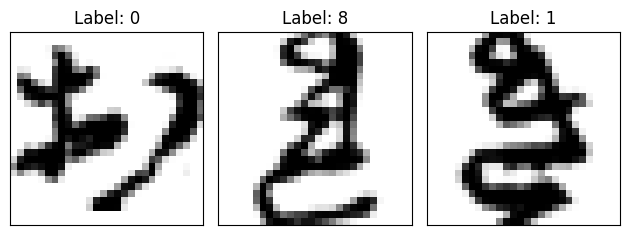

In [11]:
# Suggestions: use the plot_input function
import random 
indices = [4, 5, 6]
plot_input(x, y, indices)


### TO DO (A.1)

Now use a feed-forward Neural Network for prediction. Use the multi-layer perceptron classifier, with the following parameters: max_iter = $200$, alpha = $1 \cdot 10^{-4}$, solver = 'sgd', tol = $1 \cdot 10^{-4}$, learning_rate_init = $0.1$, random_state = ID (this last parameter ensures the run is the same even if you run it more than once). The alpha parameter is the regularization term.

Then, using the default activation function, pick four or five architectures to consider, with different numbers of hidden layers and different sizes. It is not necessary to create huge neural networks, you can limit to $3$ layers and, for each layer, its maximum size can be of $50$. Evaluate the architectures you chose using GridSearchCV with cv = $5$.

You can reduce the number of iterations if the running time is too long on your computer.

In [12]:
# These are sample values but feel free to change them as you like,
# try to experiment with different sizes!!
parameters = {'hidden_layer_sizes': [(10,), (20,), (40,), (20,20,), (40,20,10)]}

# Create a MLP classifier using scikit-learn
max_iter = 50
mlp = MLPClassifier(max_iter = max_iter, alpha=1e-4, solver = 'sgd', tol = 1e-4, learning_rate_init=0.1, random_state=42)

# Perform a grid search varying over the given parameters
clf = GridSearchCV(mlp, parameters, cv=5)
clf.fit(x_train, y_train)

# Print the best estimator parameters
print("Best parameters found: ")
print(clf.best_params_)
print("\nGrid scores on development set: ")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print(f"{mean:.3f} (+/-{std * 2:.03f}) for {params}")

Best parameters found: 
{'hidden_layer_sizes': (20,)}

Grid scores on development set: 
0.683 (+/-0.070) for {'hidden_layer_sizes': (10,)}
0.708 (+/-0.086) for {'hidden_layer_sizes': (20,)}
0.703 (+/-0.067) for {'hidden_layer_sizes': (40,)}
0.687 (+/-0.071) for {'hidden_layer_sizes': (20, 20)}
0.665 (+/-0.073) for {'hidden_layer_sizes': (40, 20, 10)}


### TO DO (A.Q1) [Answare the following] 

What do you observe for different architectures? How do the number of layers and their sizes affect the performances?

**ANSWER A.Q1:** The grid score is a measure of the performances of a neural network based on a grid of parameters. We can observe that with the increase of the number of layers the grid score is decreasing. As a consequence, the best grid score is obtained for a number of layers equal to 1 with a size of 20. Also we can notice that the size and number of layers can affect significantly the grid score and the performances of the algorithm.

### TO DO (A.2)

Plot the train and test accuracies as a function of the numbero of neurons in your neural network. Print also the computation time for the various configuration you try.

While performing the *MLP* train with different hidden layer sizes evaluate also the time spend for the training by each different configuration. You can use the `time` library to measure the time spent for the training.

In particular if you want to estimate the time elapsed for the execution of a function you can use the following code:

```python
# Import the time library
from time import time
# Define the starting time
start_time = time()
# Execute the function
function_to_evaluate()
# Compute the elapsed time
elapsed_time = time() - start_time
```

As you can see for the example above the `time()` function returns the time in seconds since the epoch as a floating point number. So, to compute the elapsed time we can simply compute the difference between the time after the execution of the function and the time before the execution of the function.

Keep in mind that to use the `time()` function we need to import the `time` library (already done at the beginning of this notebook).

Training MLP of size 10 ...
Time needed for training:  0.15163660049438477
Training MLP of size 20 ...
Time needed for training:  0.13894987106323242
Training MLP of size 40 ...
Time needed for training:  0.1298201084136963
Training MLP of size 20 ...
Time needed for training:  0.14767026901245117
Training MLP of size 30 ...
Time needed for training:  0.21395063400268555


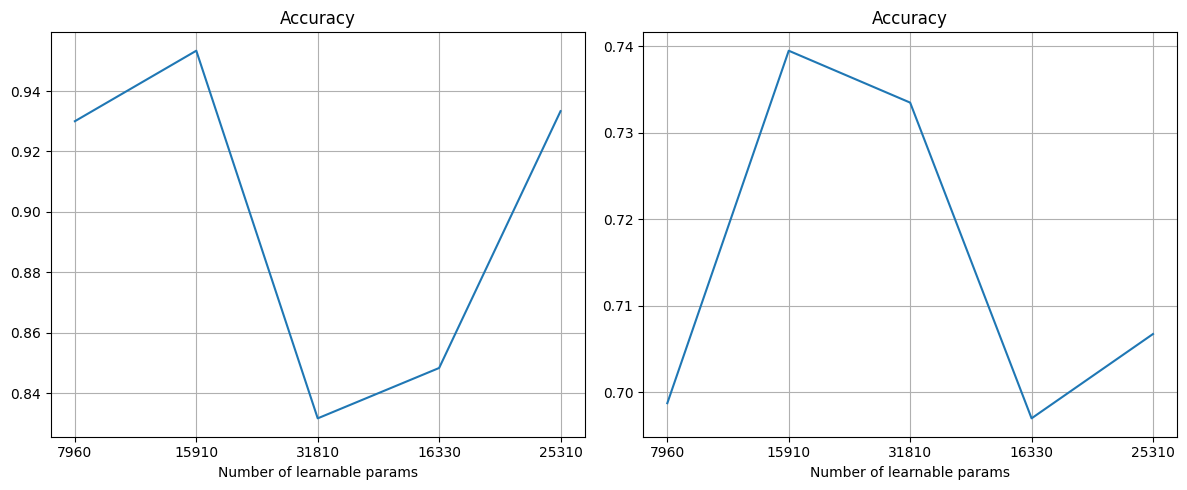

In [13]:
# Define the list of hidden layer sizes to try out (feel free to change)
# Define also the labels for the plot
hl_sizes = [(10,), (20,), (40,), (20,20,), (30,30,20)] #dimensioni degli hidden layers
hl_labels = [param_count(t, x_train, labels) for t in hl_sizes]

# Train the MLPs with the different hidden layers sizes and get the accuracies
#s_time = time()  # start time
train_acc_list, test_acc_list = [], []  # lists for saving accuracies (train and test)
training_time = []
labels_train = []
labels_test = []

param_grid = {'hl_sizes': hl_sizes}

for hl_size in hl_sizes:
    print(f"Training MLP of size {hl_size[0]} ...")

    # Define the MLP object
    mlp = MLPClassifier(hidden_layer_sizes = hl_size, max_iter = 200, alpha = 1e-4, solver = 'sgd', tol = 1e-4, learning_rate_init=0.1, random_state=42, early_stopping=True)
    
    start_time = time()
    # Train the MLP
    mlp.fit(x_train, y_train)
    predicted_labels_train = mlp.predict(x_train)
    predicted_labels_test = mlp.predict(x_test)
    
    grid_search = GridSearchCV(mlp, param_grid, cv=5)
    #grid_search.fit(x_train, y_train)
    
    labels_train.append(predicted_labels_train)
    labels_test.append(predicted_labels_test)
    
    end_time = time()
    
    training_time.append(end_time - start_time)

    # Save the accuracies in the correct lists
    train_acc_list.append(mlp.score(x_train, y_train))
    test_acc_list.append(mlp.score(x_test, y_test))

    # Print the time needed for training
    print("Time needed for training: ", end_time - start_time)

# Plot the train and test and train accuracies
# Suggestions: use the plot_accuracies function
plot_accuracies([train_acc_list, test_acc_list] , hl_labels)

#Otteniamo i migliori valori di hidden layers size e batch size (numero di parametri)
for i in range(len(test_acc_list)): 
    if test_acc_list[i] == max(test_acc_list):
        index = i


### TO DO (A.Q2) [Answare the following]

Comment about the training and test accuracies referring to the discussion on underfitting and overfitting we did in the course

**ANSWER A.Q2:** Starting from the case with a small number of parameters, we can see that there is an overfitting on the training data, observing that the accuracy on the test data is really low. In the same way, considering the case in which the number of parameters is 25310, we have a really good accuracy on training, while it is really low on the test set. We can say that it is due to the semplicity of the model, that is not able to generalize from the training set to the test set.

### TO DO (A.3)

Now try also to use different learning rates, while keeping the best *NN* architecture and batch size you have found above. Plot the learning curves (*i.e.*, the variation of the loss over the steps, you can get it from the `loss_curve_` object of sklearn) for the different values of the learning rate. Try to run each training for $600$ iterations. Plot all the curves in the same plot.

Best learning rate:  0.002


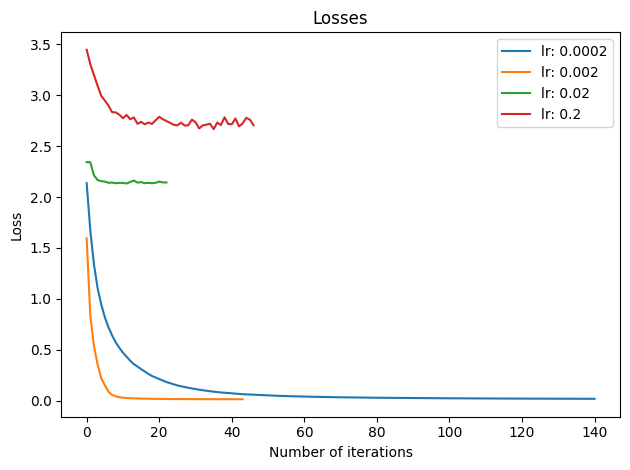

In [14]:
# Define the list of learning rates to try out (feel free to change)
lr_list = [0.0002, 0.002, 0.02, 0.2]

# Train the MLPs with the different lerning rates
scores = {}  # dictionary for saving the scores
losses = {}  # dictionary for saving losses

# Get the best hidden layer sizes and batch size from the previous MLPs
best_architecture = hl_sizes[index] #hidden layer size = numero di strati con numero di neuroni per strato(?)
best_batch_size = 1 #uso la batch size utilizzata nel caso precedente

max_iter = 600
for lr in lr_list:
    # Define the MLP object
    mlp = MLPClassifier(hidden_layer_sizes=best_architecture, max_iter=max_iter, alpha=1e-4, solver='sgd', tol=1e-4,
                        learning_rate_init=lr, batch_size=best_batch_size, random_state=42)

    # Train the MLP
    mlp.fit(x_train, y_train)

    # Save the score and the loss in the correct dictionary
    scores[lr] = mlp.score(x_test, y_test)
    losses[lr] = mlp.loss_curve_

# Print the best learning rate value and the corresponding score
print("Best learning rate: ", max(scores, key = scores.get))
best_lr = max(scores, key = scores.get)
# Plot the losses
# Suggestions: use the plot_loss function
plot_loss(losses)

### TO DO (A.Q3) [Answare the following]

Comment about the learning curves (*i.e.*, the variation of the loss over the steps). How does the curve changes for different learning rates in terms of stability and speed of convergence?

**ANSWER A.Q3:** We can see that the learning curves are much more stable with learning rates equal to 0.0002 or 0.002. At the same time, the convergence is faster for higher learning rates. We can explain this considering that with an higher learning rate the step of the gradient is higher. This cause the possibility of falling in a secondary minimum and can make the algorithm more unstable in terms of performances.  

### TO DO (A.4)

Now get training and test error for a NN with best parameters (architecture, batch size and learning rate) from above. Plot the learning curve also for this case.

Training error:  0.0
Test error:  0.239


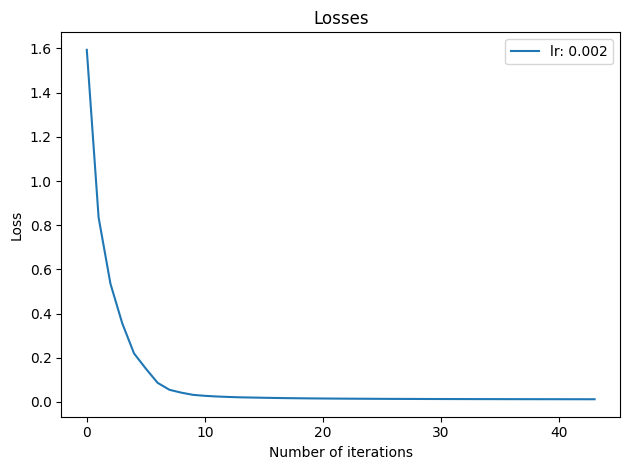

In [15]:
#get training and test error for the best NN model from CV
# Define the MLP object
mlp = MLPClassifier(hidden_layer_sizes=best_architecture, max_iter=600, alpha=1e-4, solver='sgd', tol=1e-4,
                        learning_rate_init=best_lr, batch_size=best_batch_size, random_state=42)

# Train the MLP
mlp.fit(x_train, y_train) 

# Compute the training and test error
train_predictions = mlp.predict(x_train)
train_error = 1 - mlp.score(x_train, y_train)

test_predictions = mlp.predict(x_test)
test_error = 1 - mlp.score(x_test, y_test)

# Print the training and test error
print("Training error: ", train_error)
print("Test error: ", test_error)

# Plot the loss curve for the best NN
# Suggestions: use the plot_loss function
loss = {best_lr: mlp.loss_curve_}
plot_loss(loss)

---

## B) Classification with Neural Networks (with custom implementation)

In the second part of this notebook we are going to implement a simple *MLP* from scratch. We are going to use the same dataset as before.

### TO DO (B.1)
    
Define the Activation class tha implements the activation functions and the correspondent derivative. In particular, implement the following activation functions: **relu**, **sigmoid**.

In [16]:
class Activation:
    """
    Activation function class
    """

    def __init__(self, name: str) -> None:
        """
        Constructor for the Activation class.
        Given a string name, it sets the activation function (and derivative) to be used.
        Args:
            name (str): the name of the activation function to be used.
        """

        self.name = name

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """
        Given an input x, it computes the corresponding activation function.
        \nArgs:
            x (np.ndarray): the input to the activation function. #x quindi è un array di valori 
        \nReturns:
            np.ndarray: the output of the activation function and the input x (used for backpropagation).
        """

        if self.name == 'relu':
            return np.maximum(0, x)
            
        elif self.name == 'sigmoid':
            return 1/(1+np.exp(-x))
        
        else:
            raise ValueError('Activation function not supported')

    def derivative(self, x: np.ndarray) -> np.ndarray:
        """
        Given an input x, it computes the corresponding derivative of the activation function.
        \nArgs:
            x (np.ndarray): the input to the activation function.
        \nReturns:
            np.ndarray: the derivative of the activation function.
        """

        if self.name == 'relu':
            return np.where(x > 0, 1, 0)
            
        elif self.name == 'sigmoid':
            sig_x = self(x)
            return sig_x * ( 1 - sig_x)
        else:
            raise ValueError('Activation function not supported')

### TO DO (B.2)

The following block contains the structure of the *MLP* class. You have to complete the `forward` functions. The `forward` function should compute the forward pass of the network.
Note that to be able to perform backpropagation algorithm we have to keep track of all the computation we do in the forward pass. In particular, this is done in the `cache` variable that is stored at each layer. Note that in order to work properly with the already provided `backprop()` method, the cache has to sored in a specific way. In particular we have chosen that the cache is a tuple containing `(a_prev, W, b)` where:
- `a_prev` is the output of the previous layer (np.ndarray)
- `W` is the current weight matrix (np.ndarray)
- `b` is the current bias vector (np.ndarray)

In [17]:
class DiyMlp:
    """
    A Multi-layer Perceptron implementation.
    keep in mind that all the input are considered with the batch_size as the last dimension.
    """

    def __init__(self, layers: list, learning_rate: float):
        """
        Constructor for the DiyMlp class.
        Each layer a part from the last one use as activation function the ReLU, while the last one uses the sigmoid.
        \nArgs:
            layers (list): a list of layers, each element of the list contains the number of neurons of the layer,
            learning_rate (float): the learning rate used during training
        """

        self.n_layers = len(layers)  # number of layers
        params = {}  # dictionary containing the parameters W and b of each layer

        # For each layer, we define the weight matrix W, the bias vector b and the activation function
        for l in range(1, self.n_layers):
            params[f"W{l}"] = np.random.randn(layers[l], layers[l-1]) * 0.01  # initialize the weight matrix of the layer to a normal distribution rescaled by 0.01
            params[f"b{l}"] = np.zeros((layers[l], 1))  # initialize the bias vector of the layer to zeros
            params[f"activation{l}"] = Activation("relu" if l < self.n_layers - 1 else "sigmoid")  # define the activation function of the layer

        self.params = params  # save the parameters of the network
        self.lr = learning_rate  # save the learning rate

    @staticmethod
    def one_hot(x: np.ndarray, n_classes: int) -> np.ndarray:
        """
        Given a vector x containing the labels of the samples, it returns the one-hot encoding of x.
        \nArgs:
            x (np.ndarray): the input vector containing the labels of the samples.
            n_classes (int): the number of classes.
        \nReturns:
            np.ndarray: the one-hot encoding of x.
        """

        return np.eye(n_classes)[x.reshape(-1)]

    def forward(self, x: np.ndarray) -> tp.Tuple[np.ndarray, list]:
        """
        Given an input x, it computes the forward pass of the network.
        \nArgs:
            x (np.ndarray): the input to the network.
        \nReturns:
            np.ndarray: the output of the network.
            list: a list containing the linear and activation caches.
        """

        caches = []  # list for storing the linear and activation caches

        out = None  # output of the layer

        # For each layer of the model a part the last one ...
        for l in range(1, self.n_layers):
            prev = cp(x) if l == 1 else out  # storing the input of the layer i.e. the output of the previous layer
            
            # Linear Hypothesis
            z = np.dot(self.params[f"W{l}"], prev) + self.params[f"b{l}"]  # Compute the linear hypothesis
            
            # Storing the linear cache for backpropagation = (a_prev, W, b)
            linear_cache = (prev, self.params[f"W{l}"], self.params[f"b{l}"])  # Store the linear cache
            
            #Applying the activation function on linear hypothesis
            out, activation_cache = self.params[f"activation{l}"](z),self.params[f"activation{l}"](z) # Compute the activation function
            
            #storing both the linear and activation cache
            caches.append((linear_cache, activation_cache))
        
        return out, caches
    
    @staticmethod
    def cost_function(out: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Given the output of the network out and the ground truth labels y, it computes the cost function (loss).
        This implementation uses the cross-entropy loss.
        \nArgs:
            out (np.ndarray): the output of the network.
            y (np.ndarray): the ground truth labels.
        \nReturns:
            np.ndarray: the cost value.
        """
        
        return (-1/y.shape[1]) * (np.dot(np.log(out), y.T) + np.dot(np.log(1-out), 1-y.T))

    @staticmethod
    def one_layer_backward(d_pred: np.ndarray, cache: tp.List[tp.Tuple[np.ndarray]], derivative_activation: Activation.derivative) -> tuple:
        """
        Given the derivative of the loss with respect to the output of the layer d_pred and the linear and activation cache,
        it computes the derivative of the loss with respect to the input of the layer d_pred_prev, the derivative of the loss
        with respect to the weights d_w and the derivative of the loss with respect to the bias d_b.
        \nArgs:
            d_pred (np.ndarray): the derivative of the loss with respect to the output of the layer.
            cache (list): a list containing the linear and activation cache.
            derivative_activation (Activation.derivative): the derivative of the activation function.   
        \nReturns:
            tuple: a tuple containing the derivative of the loss with respect to the input of the layer dA_prev,
            the derivative of the loss with respect to the weights dW and the derivative of the loss with respect to the bias db.
        """

        linear_cache, activation_cache = cache  # retrieve the linear and activation cache
        
        z = activation_cache
        d_z = d_pred * derivative_activation(z) # compute the derivative of the loss with respect to z
        
        pred_prev, w, _ = linear_cache  # retrieve the input of the layer and the weights from the cache
        m = pred_prev.shape[1]  # retrieve the number of samples
        
        d_w = (1/m) * np.dot(d_z, pred_prev.T)  # compute the derivative of the loss with respect to w
        d_b = (1/m) * np.sum(d_z, axis=1, keepdims=True)  # compute the derivative of the loss with respect to b
        d_pred_prev = np.dot(w.T, d_z)  # compute the derivative of the loss with respect to the input of the layer
        
        return d_pred_prev, d_w, d_b
    
    def backprop(self, pred, labels, caches) -> dict:
        """
        Given the output of the network pred, the ground truth labels y and the caches,
        it computes the backward pass of the network.
        \nArgs:
            pred (np.ndarray): the output of the network.
            labels (np.ndarray): the ground truth labels.
            caches (list): a list containing the linear and activation caches.
        \nReturns:
            dict: a dictionary containing the derivatives of the loss with respect to the parameters of the network.
        """

        grads = {}  # dictionary for storing the gradients
        labels = labels.reshape(pred.shape) # reshape the labels to have the same shape as the output of the network
        caches_len = len(caches)
        
        # Compute the grad of the last layer
        d_pred = -(np.divide(labels, pred) - np.divide(1-labels, 1-pred))  # compute the derivative of the loss with respect to the output of the network
        current_cache = caches[caches_len - 1]  # retrieve the linear and activation cache of the last layer
        grads[f"d_pred{caches_len - 1}"], grads[f"dW{caches_len}"], grads[f"db{caches_len}"] = self.one_layer_backward(d_pred, current_cache, self.params[f"activation{caches_len}"].derivative)
        
        # Compute the grad for all the other layers in reverse order
        for l in reversed(range(caches_len - 1)):
            current_cache = caches[l]  # retrieve the linear and activation cache of the layer
            grads[f"d_pred{l}"], grads[f"dW{l + 1}"], grads[f"db{l + 1}"] = self.one_layer_backward(grads[f"d_pred{l + 1}"], current_cache, self.params[f"activation{l + 1}"].derivative)  # compute the derivative of the loss with respect to the output of the next layer
            
        return grads
    
    def update_parameters(self, grads: dict) -> None:
        """
        Given the gradients grads, it updates the parameters of the network.
        \nArgs:
            grads (dict): a dictionary containing the derivatives of the loss with respect to the parameters of the network.
        """

        for l in range(self.n_layers - 1):
            self.params[f"W{l + 1}"] = self.params[f"W{l + 1}"] - self.lr*grads[f"dW{l + 1}"]
            self.params[f"b{l + 1}"] = self.params[f"b{l + 1}"] - self.lr*grads[f"db{l + 1}"]

    def train(self, x: np.ndarray, y: np.ndarray, epochs: int) -> None:
        """
        Given the input x, the ground truth labels y and the number of epochs, it trains the network.
        \nArgs:
            x (np.ndarray): the input to the network.
            y (np.ndarray): the ground truth labels.
            epochs (int): the number of epochs.
        """

        x = x.T  # transpose the input to have the batch size as the first dimension
        y = self.one_hot(y, np.unique(y).shape[0]).T  # one-hot encode the labels and transpose to have the batch size as the first dimension

        cost_history = []  # list for storing the cost at each epoch
        
        # For each epoch ...
        for _ in range(epochs):
            out, caches = self.forward(x)  # compute the output of the network and retrieve the caches
            cost = self.cost_function(out, y)  # compute the cost
            cost_history.append(cost)  # save the cost
            grads = self.backprop(out, y, caches)  # compute the gradients
            
            self.update_parameters(grads)  # update the parameters of the network using the gradients

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Given the input x, it computes the output of the network.
        \nArgs:
            x (np.ndarray): the input to the network.
        \nReturns:
            np.ndarray: the output of the network.
        """

        x = x.T  # transpose the input to have the batch size as the first dimension
        out, _ = self.forward(x)  # compute the output of the network
        predictions = np.argmax(out, axis=0)  # get the predictions
        
        return predictions

### TO DO (B.3)

Train the *MLP* you have implemented. Then print its accuracy and plot the confusion matrix to better visualize the performance of the model.

In [18]:
# Define the MLP object

mlp = DiyMlp(layers=[784, 10] , learning_rate=0.1) # Example architecture: 4 input nodes, 5 hidden nodes, 3 hidden nodes, 1 output node

# Train the MLP
mlp.train(x_train, y_train, 200)

# Compute the prediction
predictions = mlp.predict(x_test)

# Compute the accuracy on the test set and print it
accuracy = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on test set: ", accuracy)

Accuracy on test set:  0.667


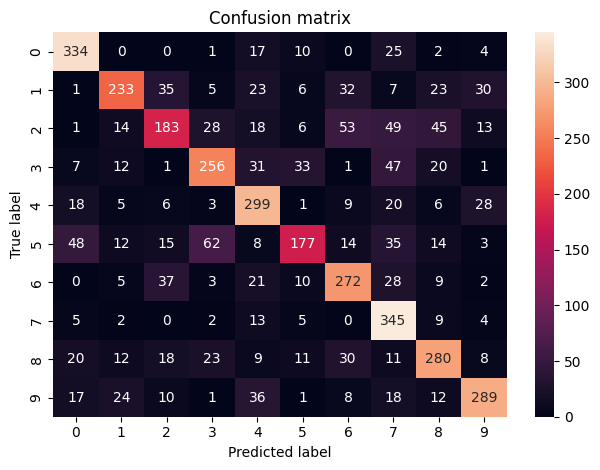

In [19]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
# Plot the confusion matrix
# Suggestions: use the plot_conf_matrix function
plot_conf_matrix(conf_matrix)

### TO DO (B.Q1) [Answare the following]

Briefly describe which is the purpose of each method of the `DiyMlp` class).

**ANSWER B.Q1:** 

* **Constructor __init__**: Initializes the neural network with a specified number of layers (defined by the layers list) and a learning rate (learning_rate). Each layer except the last one uses the ReLU activation function, while the last layer uses the sigmoid activation function.

* **Method forward**: Computes the forward pass of the neural network given input data x. It returns the output of the network and stores linear and activation caches for use in backpropagation.

* **Method cost_function**: Computes the cost function used to measure the error between the model's predictions and the ground truth labels y.

* **Method one_layer_backward**: Implements the backpropagation for a single layer of the neural network. It computes the gradients of the loss function with respect to the input of the layer, the weights, and the bias.

* **Method backprop**: Computes the backward pass of the network given the output of the network, ground truth labels, and caches obtained during the forward pass. It calculates the gradients for each layer using backpropagation.

* **Method update_parameters**: Updates the parameters of the network (weights and biases) using the gradients obtained from backpropagation and the specified learning rate.

* **Method train**: Trains the neural network by performing forward and backward passes over multiple epochs, adjusting the model's parameters to minimize the defined cost function.

* **Method predict**: Computes the output of the network given input data x after training. It performs forward propagation and returns the predicted labels.